## 内容二：蚂蚁蜜蜂分类

- **torchvision.datasets.ImageFolder加载自建数据集**

- **很多时候当我们训练一个新的图像分类任务，我们不会完全从一个随机的模型开始训练，而是利用预训练的模型来加速训练的过程。我们经常使用在ImageNet上的预训练模型**
- 有两种方法做迁移学习
    - finetuning：从一个预训练模型开始，改变一些模型的架构，然后继续训练整个模型的参数；
    - feature extraction：不改变预训练模型的参数，只更新我们改变过的部分模型参数。（当成特征提取器来使用）**

-  **Pytorch：torchvision.datasets.ImageFolder**
    - (root, transform=None, target_transform=None, loader=<function default_loader>,is_valid_file=None)


 
- 参数详解：

root：图片存储的根目录，即各类别文件夹所在目录的上一级目录。

transform：对图片进行预处理的操作（函数），原始图片作为输入，返回一个转换后的图片。

target_transform：对图片类别进行预处理的操作，输入为 target，输出对其的转换。如果不传该参数，即对 target 不做任何转换，返回的顺序索引 0,1, 2…

loader：表示数据集加载方式，通常默认加载方式即可。

is_valid_file：获取图像文件的路径并检查该文件是否为有效文件的函数(用于检查损坏文件)

返回的dataset都有以下三种属性：

self.classes：用一个 list 保存类别名称

self.class_to_idx：类别对应的索引，与不做任何转换返回的 target 对应

self.imgs：保存(img-path, class) tuple的 list

版权声明：本文为CSDN博主「万能的小黑Alex」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/qq_39507748/article/details/105394808

- **Pytorch：transforms的二十二个方法**
    - https://blog.csdn.net/weixin_38533896/article/details/86028509

In [35]:
# 导入必要的包
import numpy as np
import torch
import torchvision 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import time
import os
# import torch.utils.data as tud

from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import copy

### 观测数据start

In [50]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

#加上transforms
normalize=transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
transform=transforms.Compose([
    transforms.RandomCrop(180),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), #将图片转换为Tensor,归一化至[0,1]
    normalize
])

dataset=ImageFolder('./hymenoptera_data/train',transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 244
    Root location: ./hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(180, 180), padding=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [33]:
print(len(dataset))
print("-"*80)
print(dataset.classes)  #根据分的文件夹的名字来确定的类别
print("-"*80)
print(dataset.class_to_idx) #按顺序为这些类别定义索引为0,1...
print("-"*80)
for i in range(5):
    print(dataset.imgs[i]) #返回从所有文件夹中得到的图片的路径以及其类别
print()
print(dataset[0][0].size())#去除类别后的tensor就可以看维度了 （3, 180, 180）
print(len(dataset[0][0]))


244
--------------------------------------------------------------------------------
['ants', 'bees']
--------------------------------------------------------------------------------
{'ants': 0, 'bees': 1}
--------------------------------------------------------------------------------
('./hymenoptera_data/train\\ants\\0013035.jpg', 0)
('./hymenoptera_data/train\\ants\\1030023514_aad5c608f9.jpg', 0)
('./hymenoptera_data/train\\ants\\1095476100_3906d8afde.jpg', 0)
('./hymenoptera_data/train\\ants\\1099452230_d1949d3250.jpg', 0)
('./hymenoptera_data/train\\ants\\116570827_e9c126745d.jpg', 0)

torch.Size([3, 180, 180])
3


### 观测数据end

In [7]:
ImageFolder?

## 正式部分

In [49]:
# Data augmentation and normalization for training：训练数据的扩充和归一化
# Just normalization for validation 只是验证时标准化
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),#随机长宽比裁剪,224是输出的分辨率
        transforms.RandomHorizontalFlip(),#依据概率p对PIL图片进行水平翻转，默认值0.5
        transforms.ToTensor()#将PIL Image或者 ndarray 转换为tensor，并且归一化至[0-1]
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),# 重置图像分辨率
        transforms.CenterCrop(224),# 依据给定的size从中心裁剪 224*224
        transforms.ToTensor()
    ]),
}
#获得数据生成器，以字典的形式保存。
data_dir = 'hymenoptera_data'# 指定文件源dir
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])for x in ['train', 'val']}
#os.path.join(data_dir, x)把目录和文件名合成一个路径
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4)for x in ['train', 'val']}
image_datasets#查看数据datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: hymenoptera_data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: hymenoptera_data\val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
            )}

In [55]:
"""
print(len(image_datasets))#image_datasets包含训练和验证集
print("-"*80)
print(image_datasets['train'].classes) ## 上面的加载方式是字典，所以需要分开观测
#根据分的文件夹的名字来确定的类别
print("-"*80)
print(image_datasets['train'].class_to_idx) #按顺序为这些类别定义索引为0,1...
print("-"*80)
for i in range(5):
     print(image_datasets['train'].imgs[i]) #返回从所有文件夹中得到的图片的路径以及其类别
print()

# 查看图像通道数和维度
print(image_datasets['train'][0][0].size())#去除类别后的tensor就可以看维度了 （3, 180, 180）
print(len(image_datasets['train'][0][0]))

"""

2
--------------------------------------------------------------------------------
['ants', 'bees']
--------------------------------------------------------------------------------
{'ants': 0, 'bees': 1}
--------------------------------------------------------------------------------
('hymenoptera_data\\train\\ants\\0013035.jpg', 0)
('hymenoptera_data\\train\\ants\\1030023514_aad5c608f9.jpg', 0)
('hymenoptera_data\\train\\ants\\1095476100_3906d8afde.jpg', 0)
('hymenoptera_data\\train\\ants\\1099452230_d1949d3250.jpg', 0)
('hymenoptera_data\\train\\ants\\116570827_e9c126745d.jpg', 0)

torch.Size([3, 224, 224])
3


{'train': 244, 'val': 153}
['ants', 'bees']


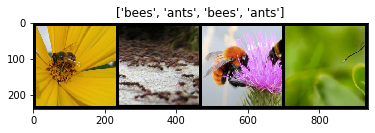

In [70]:
#选择1个batch的训练数据进行可视化
def imshow(inp, title=None):
    #"""Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)
# print(dataset_sizes)#{'train': 244, 'val': 153} 查看训练集和测试集的数量
class_names = image_datasets['train'].classes# 取训练集的类别名
print(class_names)
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs,padding=8)#make_grid的作用是将若干幅图像拼成一幅图像。其中padding的作用就是子图像与子图像之间的pad有多宽。
imshow(out, title=[class_names[x] for x in classes])
plt.show()

### 定义网络

In [ ]:
# format
def initalize_model(model_name,num_class,use_pretrained=True ,feature_extract=True):
    if model_name =="resnet18":
        model_ft= models.resnet18(pretrain=use_pretrained)
        if feature_extract:
            for parm in model_ft.parameters():
                parm.requires_grad=

In [71]:
# 训练模型函数，参数scheduler是一个 torch.optim.lr_scheduler 学习速率调整类对象
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()# 生成timestamp时间戳，时间戳表示的是从1970年1月1日00:00:00开始按秒计算的偏移量

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('-' * 20)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # 每个epoch都有一个训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # 训练模式
            else:
                model.eval()    # 验证模式

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)#数据移到GPU
                labels = labels.to(device)

                # 训练阶段开启梯度跟踪
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 仅在训练阶段进行后向+优化
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # 记录最好的状态
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('-' * 20)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 返回最佳参数的模型
    model.load_state_dict(best_model_wts)
    return model


In [73]:
net = torchvision.models.resnet18(pretrained=True)     # 加载resnet网络结构和预训练参数
num_ftrs = net.fc.in_features      # 提取fc层的输入参数
net.fc = nn.Linear(num_ftrs, 2)    # 修改输出维度为2
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

# 使用分类交叉熵 Cross-Entropy 作损失函数，动量SGD做优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 每5个epochs衰减一次学习率 new_lr = old_lr * gamma ^ (epoch/step_size)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 训练模型
net = train_model(net, criterion, optimizer, lr_scheduler, num_epochs=10)


--------------------
Epoch 1/10
train Loss: 0.6766 Acc: 0.5697
val Loss: 0.6894 Acc: 0.5359
--------------------
Epoch 2/10
train Loss: 0.6653 Acc: 0.5779
val Loss: 0.6642 Acc: 0.5948
--------------------
Epoch 3/10
train Loss: 0.6406 Acc: 0.6148
val Loss: 0.7017 Acc: 0.5294
--------------------
Epoch 4/10
train Loss: 0.6593 Acc: 0.5779
val Loss: 0.6887 Acc: 0.5359
--------------------
Epoch 5/10
train Loss: 0.6471 Acc: 0.6270
val Loss: 0.6761 Acc: 0.5556
--------------------
Epoch 6/10
train Loss: 0.6705 Acc: 0.5574
val Loss: 0.6795 Acc: 0.5686
--------------------
Epoch 7/10
train Loss: 0.6753 Acc: 0.5328
val Loss: 0.6542 Acc: 0.6209
--------------------
Epoch 8/10
train Loss: 0.6438 Acc: 0.6025
val Loss: 0.6785 Acc: 0.5752
--------------------
Epoch 9/10
train Loss: 0.6433 Acc: 0.5902
val Loss: 0.6610 Acc: 0.6144
--------------------
Epoch 10/10
train Loss: 0.6591 Acc: 0.5738
val Loss: 0.6541 Acc: 0.5882
--------------------
Training complete in 1m 57s
Best val Acc: 0.620915


In [74]:
net = torchvision.models.resnet18(pretrained=True)
# 通过设置requires_grad = False来冻结参数，这样在反向传播的时候他们的梯度就不会被计算
for param in net.parameters():
    param.requires_grad = False

# 新连接层参数默认requires_grad=True
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2)

net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.fc.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

net = train_model(net, criterion, optimizer, lr_scheduler, num_epochs=20)


--------------------
Epoch 1/20
train Loss: 0.7167 Acc: 0.5246
val Loss: 0.6972 Acc: 0.5490
--------------------
Epoch 2/20
train Loss: 0.7263 Acc: 0.4877
val Loss: 0.7023 Acc: 0.5817
--------------------
Epoch 3/20
train Loss: 0.7495 Acc: 0.4467
val Loss: 0.7203 Acc: 0.5425
--------------------
Epoch 4/20
train Loss: 0.7334 Acc: 0.4795
val Loss: 0.7049 Acc: 0.6209
--------------------
Epoch 5/20
train Loss: 0.7197 Acc: 0.4754
val Loss: 0.7061 Acc: 0.5490
--------------------
Epoch 6/20
train Loss: 0.7281 Acc: 0.4672
val Loss: 0.7191 Acc: 0.5229
--------------------
Epoch 7/20
train Loss: 0.7330 Acc: 0.4877
val Loss: 0.7128 Acc: 0.5229
--------------------
Epoch 8/20
train Loss: 0.7251 Acc: 0.4877
val Loss: 0.7090 Acc: 0.5294
--------------------
Epoch 9/20
train Loss: 0.7115 Acc: 0.5123
val Loss: 0.7095 Acc: 0.5556
--------------------
Epoch 10/20
train Loss: 0.7238 Acc: 0.5246
val Loss: 0.7154 Acc: 0.5359
--------------------
Epoch 11/20
train Loss: 0.7162 Acc: 0.4918
val Loss: 0.718